This creates a model using the training data set.

In [18]:
from __future__ import absolute_import, division, print_function, unicode_literals

seed = 23

import tensorflow as tf
import tensorflow_addons as tfa
from tensorflow import keras 
from tensorflow.keras import Input, layers
tf.keras.backend.clear_session() # for easy reset of notebook state

import numpy as np
np.random.random_seed = 23
import pandas as pd

from sklearn.model_selection import KFold

from matplotlib import pyplot as plt
from IPython import display
import pydot
from graphviz import Digraph
from matplotlib import pyplot as plt
from IPython import display

Notes:

Import the DF of genre lists and gender:

In [19]:
%store -r now
now
X_train = pd.read_csv('/Users/Daniel/Code/Genre/data/genre_lists/data_ready_for_model/wiki-kaggle_X_train_{}.csv'.format(now), index_col = ['artist'])
y_train = pd.read_csv('/Users/Daniel/Code/Genre/data/genre_lists/data_ready_for_model/wiki-kaggle_y_train_{}.csv'.format(now), index_col = ['artist'])

### Genre Labels -- as a list

Each value of the genre column is a _string_ of comma separated genre labels using the spotify abbreviations. We want to convert it to a _list_ of strings.

In [20]:
"""This function takes in a string of the form
appearing in the genrelist of the dataframe.
It strips the square brackets and extra quotes and
returns a list of strings where each string is a genre label."""
def genrelist(string):
    string = string.strip("[").strip("]").replace("'","")
    L = [s for s in string.split(',')]
    L_new = []
    for x in L:
        L_new.append(x.replace(" ","_").lstrip("_").rstrip("_"))
    while (str("") in L_new):
        L_new.remove("")
    return L_new

Now we apply
- it to the whole column and put the lists in a new column
- assemble X,y into DF
-reset index to 'artist_id'

In [21]:
X_train['genrelist']= X_train['genrelist'].apply(genrelist)

data = X_train.join(y_train, how = 'inner', on = 'artist')

data.reset_index(inplace = True)
data.index.name = 'artist_id'
data_set_size = data.shape[0]

- Full genre_list (not just that for the training set)
- Vocab Dict and Size
- max length of lists

In [22]:
genre_list = pd.read_csv('/Users/Daniel/Code/Genre/data/genre_lists/data_ready_for_model/genre_list_{}.csv'.format(now))
genre_list.drop(['Unnamed: 0'], axis = 1, inplace = True)
genre_list['genre_id'] = list(range(1,genre_list.shape[0]+1))

#Size of the vocab:
vocab_size = genre_list.shape[0]

#Create a dictionary {genre_label: genre_id}
genre_list.set_index(['genre_list'], inplace = True)
label_id_dict = genre_list['genre_id'].to_dict()

#Find max length of genre lists:
max_list_length = data.genrelist_length.max()

In [23]:
# encode labels as ints within the list
def encode_list(row):
    return [label_id_dict[item] for item in row.genrelist]

data['genres_encoded_as_list'] = data.apply(encode_list, axis = 1)

#Check that the encoding is consistent: 
# n = np.random.randint(data.shape[0])
# [label_id_dict[item] for item in data.genrelist.iloc[n]], data.genres_encoded_as_list.iloc[n]

#Encode into new columns

#create columns with zeros
for i in range(73):
    data['label_{}'.format(i)] = np.zeros((data.shape[0]), dtype = 'int64')
    
def encode_columns(row):
    for i, id in enumerate(row.genres_encoded_as_list):
        row.loc['label_{}'.format(i)] = id
    return row

data = data.apply(encode_columns, axis = 1)

# Encode targets. The categories still appear as strings. To see the encoding use df.column.cat.codes.
data['gender'] = data.gender.apply(lambda x: 1 if x == 'female' else 0)

### Scale genrelist_length
- currently use sqrt to separate low values

In [24]:
data.genrelist_length.sort_values(ascending = False).head()

artist_id
11822    73
5533     45
8669     15
258      15
1226     14
Name: genrelist_length, dtype: int64

Flatten out the outliers:

In [25]:
def smoosh(row):
    if row.genrelist_length > 60:
        return 16
    if row.genrelist_length > 14:
        return 15
    else:
        return row.genrelist_length

data['genrelist_length'] = data.apply(smoosh, axis = 1)
#data.genrelist_length.sort_values(ascending = False)

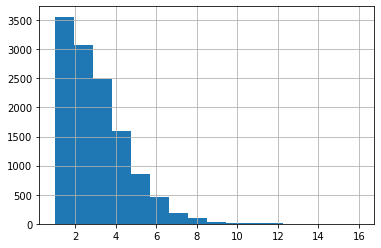

In [26]:
data.genrelist_length.hist(bins = 16)

Normalize on copy of data:

In [27]:
data_norm = data.copy()

### Nonlinear scaling seems to be helpful!

In [28]:
# this is chosen to match the min, max of the untrained embedding layer
def normalize_length(x):
    #x = .1*np.power(x/x.max(),1)-.05
    x = .1*np.power(x/x.max(),.5)-.05
    return x

In [29]:
normalize_length(np.array(range(16)))

array([-0.05      , -0.02418011, -0.01348516, -0.00527864,  0.00163978,
        0.00773503,  0.01324555,  0.01831301,  0.02302967,  0.02745967,
        0.03164966,  0.03563488,  0.03944272,  0.04309493,  0.04660918,
        0.05      ])

In [30]:
data_norm['length_scaled'] = normalize_length(data_norm['genrelist_length'])

In [31]:
data_norm = data_norm.drop(['artist','genrelist', 'genres_encoded_as_list', 'genrelist_length'], axis = 1)
cols = ['gender','length_scaled']+['label_{}'.format(i) for i in range(73)]
cols
data_norm = data_norm[cols]
# Shuffle the data:
data_norm = data_norm.sample(frac = 1)

In [32]:
data_norm.head()

,gender,length_scaled,label_0,label_1,label_2,label_3,label_4,label_5,label_6,label_7,...,label_63,label_64,label_65,label_66,label_67,label_68,label_69,label_70,label_71,label_72
artist_id,,,,,,,,,,,,,,,,,,,,,
9373,1,-0.006699,1025,1007,629,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
7065,1,-0.014645,465,368,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2827,0,-0.006699,1481,1270,227,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
306,0,-0.025000,465,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
444,0,-0.006699,264,1431,653,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


Now split into X,y DFs

In [33]:
y = data_norm.pop('gender')
X = data_norm.copy()

## Define Models

In [35]:
# def create_model():
#     loss_fcn = keras.losses.BinaryCrossentropy(from_logits=True)
#     #lr = .001
#     initial_lr = .001
#     lr_schedule = tf.keras.optimizers.schedules.ExponentialDecay(
#     initial_learning_rate = initial_lr,
#     decay_steps = 4000,
#     decay_rate = .8,
#     staircase = True
#     )
#     lam = .0001
#     #opt = tfa.optimizers.AdamW(lr = lr, weight_decay = .001)
#     opt = tf.keras.optimizers.Adam(learning_rate = lr_schedule)
    
#     reg = tf.keras.regularizers.l2(lam)
    
#     # the list input; use vocab_size+1 since 0 is saved to indicate no label
#     list_input = layers.Input(shape = (max_list_length,), name = 'list_input')
#     embed = layers.Embedding(input_dim = vocab_size+1, output_dim = 500, input_length = max_list_length, name = 'list_embed')(list_input)
#     pool = layers.GlobalAveragePooling1D()(embed)
#     # the length input
#     length_input = layers.Input(shape = (1,), name = 'length_input')
#     # concatenate two inputs
#     x = layers.concatenate([pool, length_input])
#     # add dense layers
#     x = layers.Dense(64, activation = 'relu')(x)
#     x = layers.concatenate([x, length_input])
#     x = layers.Dropout(.4)(x)
#     # bring length input back
#     x = layers.Dense(64, activation = 'relu')(x)
#     x = layers.Dropout(.4)(x)
#     x = layers.Dense(32, activation = 'relu')(x)
#     x = layers.Dropout(.4)(x)
#     x = layers.Dense(32, activation = 'relu')(x)
#     pred = layers.Dense(1, name = 'predictions')(x)

#     model = keras.Model(inputs = [list_input, length_input], outputs = [pred])
    
    
#     model.compile(loss=loss_fcn,
#                   optimizer=opt,
#                   metrics=['accuracy'])
    
#     return model

In [34]:
# achieved mean acc of 76% with std 1% using 10-fold cross validation
def create_model():
    loss_fcn = keras.losses.BinaryCrossentropy(from_logits=True)
    lr = .0005 # was .001
    initial_lr = .005
    lr_schedule = tf.keras.optimizers.schedules.ExponentialDecay(
    initial_learning_rate = initial_lr,
    decay_steps = 4000,
    decay_rate = .8,
    staircase = True
    )
    lam = .0001
    #opt = tfa.optimizers.AdamW(lr = lr, weight_decay = .001)
    opt = tf.keras.optimizers.Adam(learning_rate = lr)
    
    reg = tf.keras.regularizers.l2(lam)
    
    # the list input; use vocab_size+1 since 0 is saved to indicate no label
    list_input = layers.Input(shape = (max_list_length,), name = 'list_input')
    embed = layers.Embedding(input_dim = vocab_size+1, output_dim = 125, input_length = max_list_length, name = 'list_embed')(list_input)
    pool = layers.GlobalAveragePooling1D()(embed)
    # the length input
    length_input = layers.Input(shape = (1,), name = 'length_input')
    # concatenate two inputs
    x = layers.concatenate([pool, length_input])
    # add dense layers
    x = layers.Dense(64, activation = 'relu')(x)
    x = layers.concatenate([x, length_input])
    x = layers.Dropout(.5)(x)
    # bring length input back
    x = layers.Dense(64, activation = 'relu')(x)
    x = layers.Dropout(.5)(x)
    x = layers.Dense(64, activation = 'relu')(x)
    x = layers.Dropout(.5)(x)
    x = layers.Dense(64, activation = 'relu')(x) 
    pred = layers.Dense(1, name = 'predictions')(x)

    model = keras.Model(inputs = [list_input, length_input], outputs = [pred])
    
    
    model.compile(loss=loss_fcn,
                  optimizer=opt,
                  metrics=['accuracy'])
    
    return model

GlobalAveragePooling or Flatten?

In [37]:
# # to fiddle with
# def create_model():
    
#     # the list input; use vocab_size+1 since 0 is saved to indicate no label
#     list_input = layers.Input(shape = (max_list_length,), name = 'list_input')
#     embed = layers.Embedding(input_dim = vocab_size+1, output_dim = 125, input_length = max_list_length, name = 'list_embed')(list_input)
#     pool = layers.GlobalAveragePooling1D()(embed)
#     #pool = layers.Flatten()(embed)
#     # the length input
#     length_input = layers.Input(shape = (1,), name = 'length_input')
#     # concatenate two inputs
#     x = layers.concatenate([pool, length_input])
#     # add dense layers
#     x = layers.Dense(64, activation = 'relu')(x)
#     x = layers.concatenate([x, length_input])
#     x = layers.Dropout(.5)(x)
#     # bring length input back
#     x = layers.Dense(64, activation = 'relu')(x)
#     x = layers.Dropout(.5)(x)
#     x = layers.Dense(64, activation = 'relu')(x)
#     x = layers.Dropout(.5)(x)
#     x = layers.Dense(64, activation = 'relu')(x) # was 32
#     pred = layers.Dense(1, name = 'predictions')(x)

#     model = keras.Model(inputs = [list_input, length_input], outputs = [pred])
    
#     return model

In [38]:
# need to install pydot (pip) and graphviz (conda)
#keras.utils.plot_model(model, 'dnn_0_model_graph.png', show_shapes = True)

In [39]:
#model.summary()

In [40]:
# embed = layers.Embedding(input_dim = vocab_size+1, output_dim = 125, input_length = max_list_length, name = 'list_embed')

# X_values = X.values

# X_0_train = X_values[:,0:1]
# X_1_train = X_values[:,1:74]

In [42]:
# min([embed(X_1_train[i]).numpy().min() for i in range(X_1_train.shape[0])]), max([embed(X_1_train[i]).numpy().max() for i in range(X_1_train.shape[0])])

### Train Model

In [35]:
X_values = X.values
y_values = y.values

X_0_train = X_values[:,0:1]
X_1_train = X_values[:,1:74]
y_train = np.asarray(y_values)

model = create_model()

history = model.fit({'list_input':X_1_train, 'length_input':X_0_train},
                    {'predictions':y_train},
                    batch_size=64,
                    epochs=40,
                    validation_split = .2,
                    verbose = 1
                    )

Epoch 1/40
155/155 [==============================] - 1s 7ms/step - loss: 0.6372 - accuracy: 0.6873 - val_loss: 0.6163 - val_accuracy: 0.6967
Epoch 2/40
155/155 [==============================] - 1s 5ms/step - loss: 0.6227 - accuracy: 0.6873 - val_loss: 0.6093 - val_accuracy: 0.6967
Epoch 3/40
155/155 [==============================] - 1s 6ms/step - loss: 0.6124 - accuracy: 0.6873 - val_loss: 0.5900 - val_accuracy: 0.6967
Epoch 4/40
155/155 [==============================] - 1s 6ms/step - loss: 0.5740 - accuracy: 0.6873 - val_loss: 0.5318 - val_accuracy: 0.6967
Epoch 5/40
155/155 [==============================] - 1s 6ms/step - loss: 0.5395 - accuracy: 0.6873 - val_loss: 0.5170 - val_accuracy: 0.6967
Epoch 6/40
155/155 [==============================] - 1s 6ms/step - loss: 0.5203 - accuracy: 0.6886 - val_loss: 0.5300 - val_accuracy: 0.6967
Epoch 7/40
155/155 [==============================] - 1s 6ms/step - loss: 0.5162 - accuracy: 0.6889 - val_loss: 0.5130 - val_accuracy: 0.6967
Epoch 

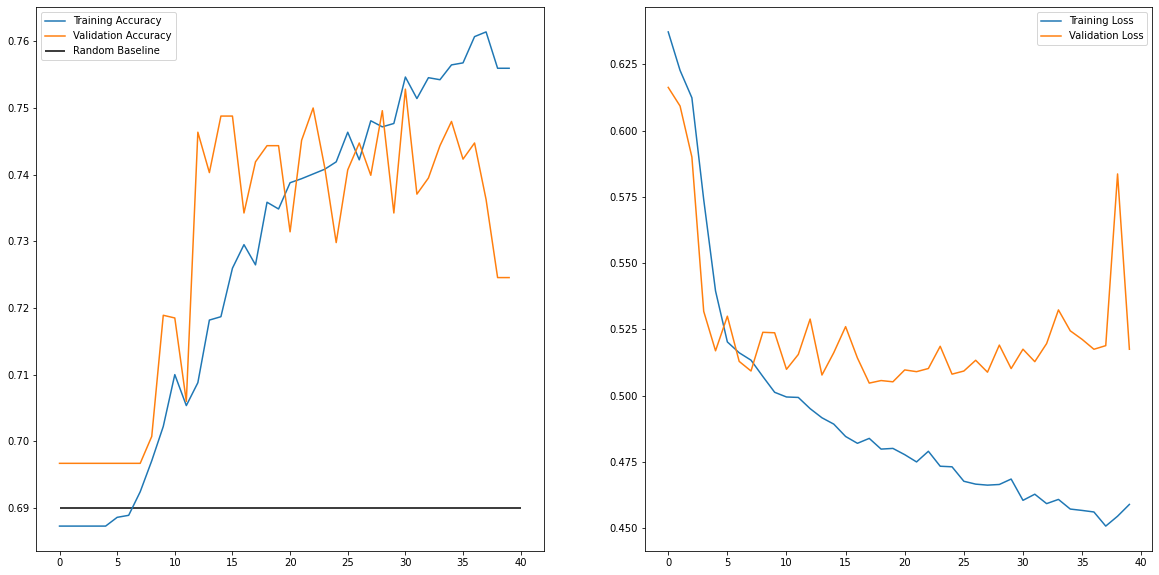

In [36]:
fig, axs = plt.subplots(1,2, figsize = (20,10))

axs[0].plot(history.history['accuracy'], label = 'Training Accuracy')
axs[0].plot(history.history['val_accuracy'], label = 'Validation Accuracy')

axs[1].plot(history.history['loss'], label = 'Training Loss')
axs[1].plot(history.history['val_loss'], label = 'Validation Loss')

axs[0].hlines(0.69,0,len(history.history['accuracy']), label = 'Random Baseline')
#plt.ylim(0,.1)
axs[0].legend()
axs[1].legend()

plt.show()
#print(min(history.history['accuracy']))

Train with cross validation:

In [103]:
kf = KFold(n_splits = 10, shuffle = True, random_state = seed)

cvscores_acc = []

X_values = X.values
y_values = y.values

for train, test in kf.split(X_values,y_values):
    
    X_0_train = X_values[train,0:1]
    X_1_train = X_values[train,1:74]
    y_train = np.asarray(y_values[train])
    
    #print(X_0_train.shape, X_1_train.shape, y_train.shape)
    
    model = create_model()
    
#     dataset_length_train = tf.data.Dataset.from_tensor_slices((X_0_train, y_train)) 
#     dataset_list_train = tf.data.Dataset.from_tensor_slices((X_1_train, y_train)) 
    
    history = model.fit({'list_input':X_1_train, 'length_input':X_0_train},
                    {'predictions':y_train},
                    batch_size=16,
                    epochs=33,
                    verbose = 0 
                    )
    
    
    X_0_test = X_values[test,0:1]
    X_1_test = X_values[test,1:73]
    y_test = y_values[test]
    
#     dataset_length_test = tf.data.Dataset.from_tensor_slices((X_0_test, y_test)) 
#     dataset_list_test = tf.data.Dataset.from_tensor_slices((X_1_test, y_test)) 
    
    scores = model.evaluate(
                    {'list_input':X_1_train, 'length_input':X_0_train},
                    {'predictions':y_train},
                    verbose = 0)
    
    print(f'Accuracy = {scores[1]}.')
    cvscores_acc.append(scores[1])
    

print(f'Mean Accuracy is {np.mean(cvscores_acc):.4f} and STD of Accuracy is {np.std(cvscores_acc):.4f}')

Accuracy = 0.7580355405807495.
Accuracy = 0.7590231895446777.
Accuracy = 0.757317304611206.
Accuracy = 0.7772490382194519.
Accuracy = 0.757586658000946.
Accuracy = 0.7738373279571533.
Accuracy = 0.7435137629508972.
Accuracy = 0.7475536465644836.
Accuracy = 0.7737678289413452.
Accuracy = 0.7674835920333862.
Mean Accuracy is 0.7615 and STD of Accuracy is 0.0107


Ignore for now: Another possibility: Create TF Dataset using the corpus from gensim as a generator: Another possibility: Create TF Dataset using the corpus from gensim as a generator:

In [ ]:
def corpus_gen():
    for i in len(corpus):
        yield (i, corpus[i])

In [ ]:
dataset = tf.data.Dataset.from_generator(
    corpus_gen,
    (tf.int64, --tensor_one_hot--)
)